In [1]:
from rainymotion import models, metrics, utils
from collections import OrderedDict
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = h5py.File("../../data/data.h5", mode="r")  # "data.h5" (mode r)
# dictionary structure: {"t": [ [t-24, t-23,..., t-1], [t+1,...,t+12] ]}
eval_idx = np.load("../../data/eval_dict.npy",allow_pickle=True).item()

In [3]:
eval_instance = eval_idx
data_instance = data
model = models.Sparse()

if True:
    key = sorted(list(eval_instance.keys()))[0]    
#for key in sorted(list(eval_instance.keys())):
    inputs = np.array([ data_instance[key][:] for key in eval_instance[key][0] ])
    model.input_data = inputs
    nowcast = model.run()  # shape (12, 900, 900)

In [4]:
self = model

In [5]:
import skimage.transform as sktf
from rainymotion.models import _sparse_linear,_sparse_sd
transformations = {'euclidean': sktf.EuclideanTransform(),
                   'similarity': sktf.SimilarityTransform(),
                   'affine': sktf.AffineTransform(),
                   'projective': sktf.ProjectiveTransform()}

# scale input data to uint8 [0-255] with self.scaler
data_scaled, c1, c2 = self.scaler(self.input_data) # shape (24, 900, 900)

# set up transformer object
trf = transformations[self.warper]  # 3x3 transform matrix

# obtain source and target points
if self.extrapolation == "linear":
    pts_source, pts_target_container = _sparse_linear(data_instance=data_scaled,
                                                      of_params=self.of_params,
                                                      lead_steps=self.lead_steps)
elif self.extrapolation == "simple_delta":
    pts_source, pts_target_container = _sparse_sd(data_instance=data_scaled,
               of_params=self.of_params, lead_steps=self.lead_steps) # (128,2),12 elements of (128,2) 

# container for our nowcasts
last_frame = data_scaled[-1]
nowcst_frames = []

for lead_step, pts_target in enumerate(pts_target_container):

    # estimate transformation matrix
    # based on source and traget points
    trf.estimate(pts_source, pts_target)

    # make a nowcast
    nowcst_frame = sktf.warp(last_frame/255, trf.inverse)
    # transformations dealing with strange behaviour
    nowcst_frame = (nowcst_frame*255).astype('uint8')
    # add to the container
    nowcst_frames.append(nowcst_frame)

nowcst_frames = np.stack(nowcst_frames, axis=0)

nowcst_frames = self.inverse_scaler(nowcst_frames, c1, c2)

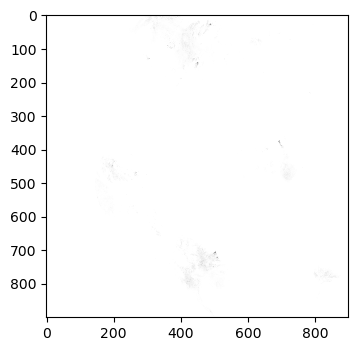

In [16]:
plt.figure(dpi = 100)
plt.imshow(data_instance["201605291205"][:].astype('float32'), cmap='gray_r')
plt.show()

### _sparse_linear( )

In [18]:
import cv2
data_instance = data_scaled  # (24, 900, 900)
of_params={'st_pars': dict(maxCorners = 200,qualityLevel = 0.2,minDistance = 7,blockSize = 21),
            'lk_pars': dict(winSize = (20, 20),maxLevel = 2,
                            criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0))}

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

extrapol_params={"model": LinearRegression(),"features": "ordinal"}

old_corners = cv2.goodFeaturesToTrack(data_instance[0], mask=None,**of_params['st_pars'])

# Set containers to collect results (time steps in rows, detected corners
# in columns)

#   corner x coords
x = np.full((data_instance.shape[0], len(old_corners)), np.nan)  # shape (24,200)
#   corner y coords
y = np.full((data_instance.shape[0], len(old_corners)), np.nan)
#   Assign persistent corner IDs
ids = np.arange(len(old_corners))  # [0,199]

# fill in first values
x[0, :] = old_corners[:, 0, 0]
y[0, :] = old_corners[:, 0, 1]

# track corners for each time frame by optical flow algorithm
for i in range(1, data_instance.shape[0]):
    new_corners, st, err = cv2.calcOpticalFlowPyrLK(prevImg = data_instance[i-1],
                                                    nextImg = data_instance[i],
                                                    prevPts = old_corners,
                                                    nextPts = None,
                                                    **of_params['lk_pars'])

    # select only good attempts for corner tracking
    success = st.ravel() == 1
    # use only sucessfull ids for filling
    ids = ids[success]
    # fill in results
    x[i, ids] = new_corners[success, 0, 0]
    y[i, ids] = new_corners[success, 0, 1]
    # new corners will be old in the next loop
    old_corners = new_corners[success]

# consider only full paths
full_paths_without_nan = [np.sum(np.isnan(x[:, i])) == 0 for i in range(x.shape[1])]
x = x[:, full_paths_without_nan].copy()  # shape(24,187)
y = y[:, full_paths_without_nan].copy()

# containers for corners predictions
x_new = np.full((lead_steps, x.shape[1]), np.nan)  # (12, 187)
y_new = np.full((lead_steps, y.shape[1]), np.nan)

for i in range(x.shape[1]):
    x_train = x[:, i]
    y_train = y[:, i]
    X = np.arange(x.shape[0] + lead_steps)  # [0,1,2, ..., 35]

    if extrapol_params["features"] == "polynomial":
        polyfeatures = PolynomialFeatures(2)
        X = polyfeatures.fit_transform(X.reshape(-1, 1))
        X_train = X[:x.shape[0], :]
        X_pred = X[x.shape[0]:, :]
    else:
        X = X.reshape(-1, 1)   # (36,1)
        X_train = X[:x.shape[0], :]
        X_pred = X[x.shape[0]:, :]

    x_pred = extrapol_params["model"].fit(X_train, x_train).predict(X_pred)
    y_pred = extrapol_params["model"].fit(X_train, y_train).predict(X_pred)

    x_new[:, i] = x_pred
    y_new[:, i] = y_pred

# define source corners in appropriate format
pts_source = np.hstack([x[-1, :].reshape(-1, 1), y[-1, :].reshape(-1, 1)])

# define container for targets in appropriate format
pts_target_container = [np.hstack([x_new[i, :].reshape(-1, 1),
                                   y_new[i, :].reshape(-1, 1)]) for i in range(x_new.shape[0])]

In [34]:
x_new.shape

(12, 187)

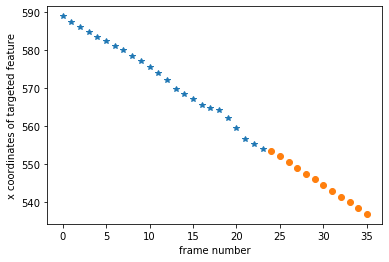

In [44]:
plt.plot(X_train,x_train,'*')
plt.plot(X_pred,x_pred,'o')
plt.ylabel("x coordinates of targeted feature")
plt.xlabel("frame number")
plt.show()